<a href="https://www.kaggle.com/code/utkarshx27/machine-failure-prediction?scriptVersionId=135419206" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/machine-failure-predictions/machine failure.csv
/kaggle/input/playground-series-s3e17/sample_submission.csv
/kaggle/input/playground-series-s3e17/train.csv
/kaggle/input/playground-series-s3e17/test.csv


In [2]:
import math
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from scipy.stats.mstats import winsorize
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, cross_val_score
from xgboost import XGBClassifier
from catboost import CatBoostRegressor as cbr
from lightgbm import LGBMRegressor as lgbmr
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s3e17/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e17/test.csv')
sample_sub = pd.read_csv('/kaggle/input/playground-series-s3e17/sample_submission.csv')

# Data OverView

In [4]:
train.head(2)

id Product ID Type  Air temperature [K]  Process temperature [K]  \
0   0     L50096    L                300.6                    309.6   
1   1     M20343    M                302.6                    312.1   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1596         36.1              140                0    0   
1                    1759         29.1              200                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0

In [5]:
test.head(2)

id Product ID Type  Air temperature [K]  Process temperature [K]  \
0  136429     L50896    L                302.3                    311.5   
1  136430     L53866    L                301.7                    311.0   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  TWF  HDF  PWF  OSF  \
0                    1499         38.0               60    0    0    0    0   
1                    1713         28.8               17    0    0    0    0   

   RNF  
0    0  
1    0

In [6]:
sample_sub.head(2)

id  Machine failure
0  136429              0.5
1  136430              0.5

# Data Statistics Summary

In [7]:
def summary(df):
    print(f'data shape: {df.shape}')  
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['missing'] = df.isnull().sum().values 
    summ['missing'] = df.isnull().sum().values / len(df)* 100
    summ['unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    return summ
summary(train)

data shape: (136429, 14)


data type  missing  unique     min       max
id                          int64      0.0  136429     0.0  136428.0
Product ID                 object      0.0    9976     NaN       NaN
Type                       object      0.0       3     NaN       NaN
Air temperature [K]       float64      0.0      95   295.3     304.4
Process temperature [K]   float64      0.0      81   305.8     313.8
Rotational speed [rpm]      int64      0.0     952  1181.0    2886.0
Torque [Nm]               float64      0.0     611     3.8      76.6
Tool wear [min]             int64      0.0     246     0.0     253.0
Machine failure             int64      0.0       2     0.0       1.0
TWF                         int64      0.0       2     0.0       1.0
HDF                         int64      0.0       2     0.0       1.0
PWF                         int64      0.0       2     0.0       1.0
OSF                         int64      0.0       2     0.0       1.0
RNF                         int64      0.0       2     0.0       1.0

Summary:

- The dataset has 136,429 rows and 14 columns.
- The columns contain a mix of data types, including integers, floats, and objects.
- There are no missing values in the dataset.
- The number of unique values varies across columns, suggesting a range of categorical or discrete variables.
- The range of values varies for different columns. For example, the 'Air temperature [K]' column ranges from 295.3 to 304.4, while the 'Tool wear [min]' column ranges from 0.0 to 253.0.
- The column 'Machine failure' is a binary variable with values 0 and 1.
- The columns 'TWF', 'HDF', 'PWF', 'OSF', and 'RNF' are also binary variables with values 0 and 1.

# Target Column Distribution

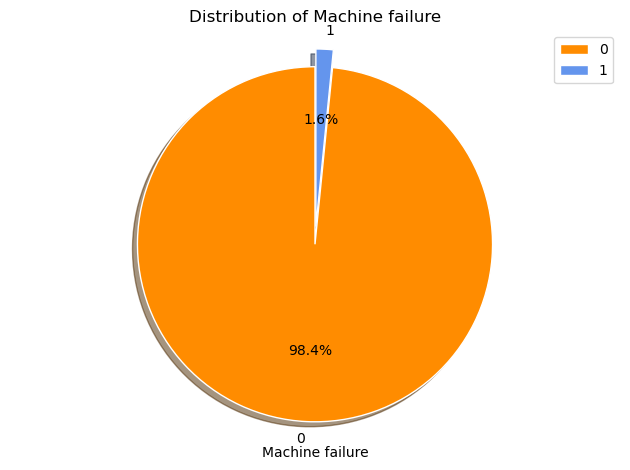

In [8]:
class_counts = train['Machine failure'].value_counts()

colors = ['#FF8C00', '#6495ED']

plt.pie(class_counts, 
        labels=class_counts.index, 
        autopct='%1.1f%%',
        colors=colors,           
        shadow=True,             
        startangle=90,            
        explode=(0.1, 0),        
        wedgeprops={'edgecolor': 'white'} 
        )

plt.legend(class_counts.index, loc='best')
plt.xlabel('Machine failure')
plt.title('Distribution of Machine failure')

plt.axis('equal')
plt.tight_layout()

plt.show()

# Pre-processing and Feature Engineering

In [9]:
def preprocessing(df):
    df.columns = df.columns.str.replace('[\[\]]', '', regex=True)
    
    categorical_cols = ["Type"]
    encoder = OrdinalEncoder()
    df[categorical_cols] = encoder.fit_transform(df[categorical_cols])
    
    
    df["Power"] = df["Torque Nm"] * df["Rotational speed rpm"]
    df["temp_ratio"] = df["Process temperature K"] / df["Air temperature K"]
    df["Temperature ratio"] = df['Process temperature K'] / df['Air temperature K']
    df['Torque * Rotational speed rpm'] = df['Torque Nm'] * df['Rotational speed rpm']
    df['Torque * Tool wear'] = df['Torque Nm'] * df['Tool wear min']
    df['Torque * Rotational speed rpm'] = df['Torque Nm'] * df['Rotational speed rpm']
    
    return df

train = preprocessing(train)
test = preprocessing(test)

# Feature Distribution

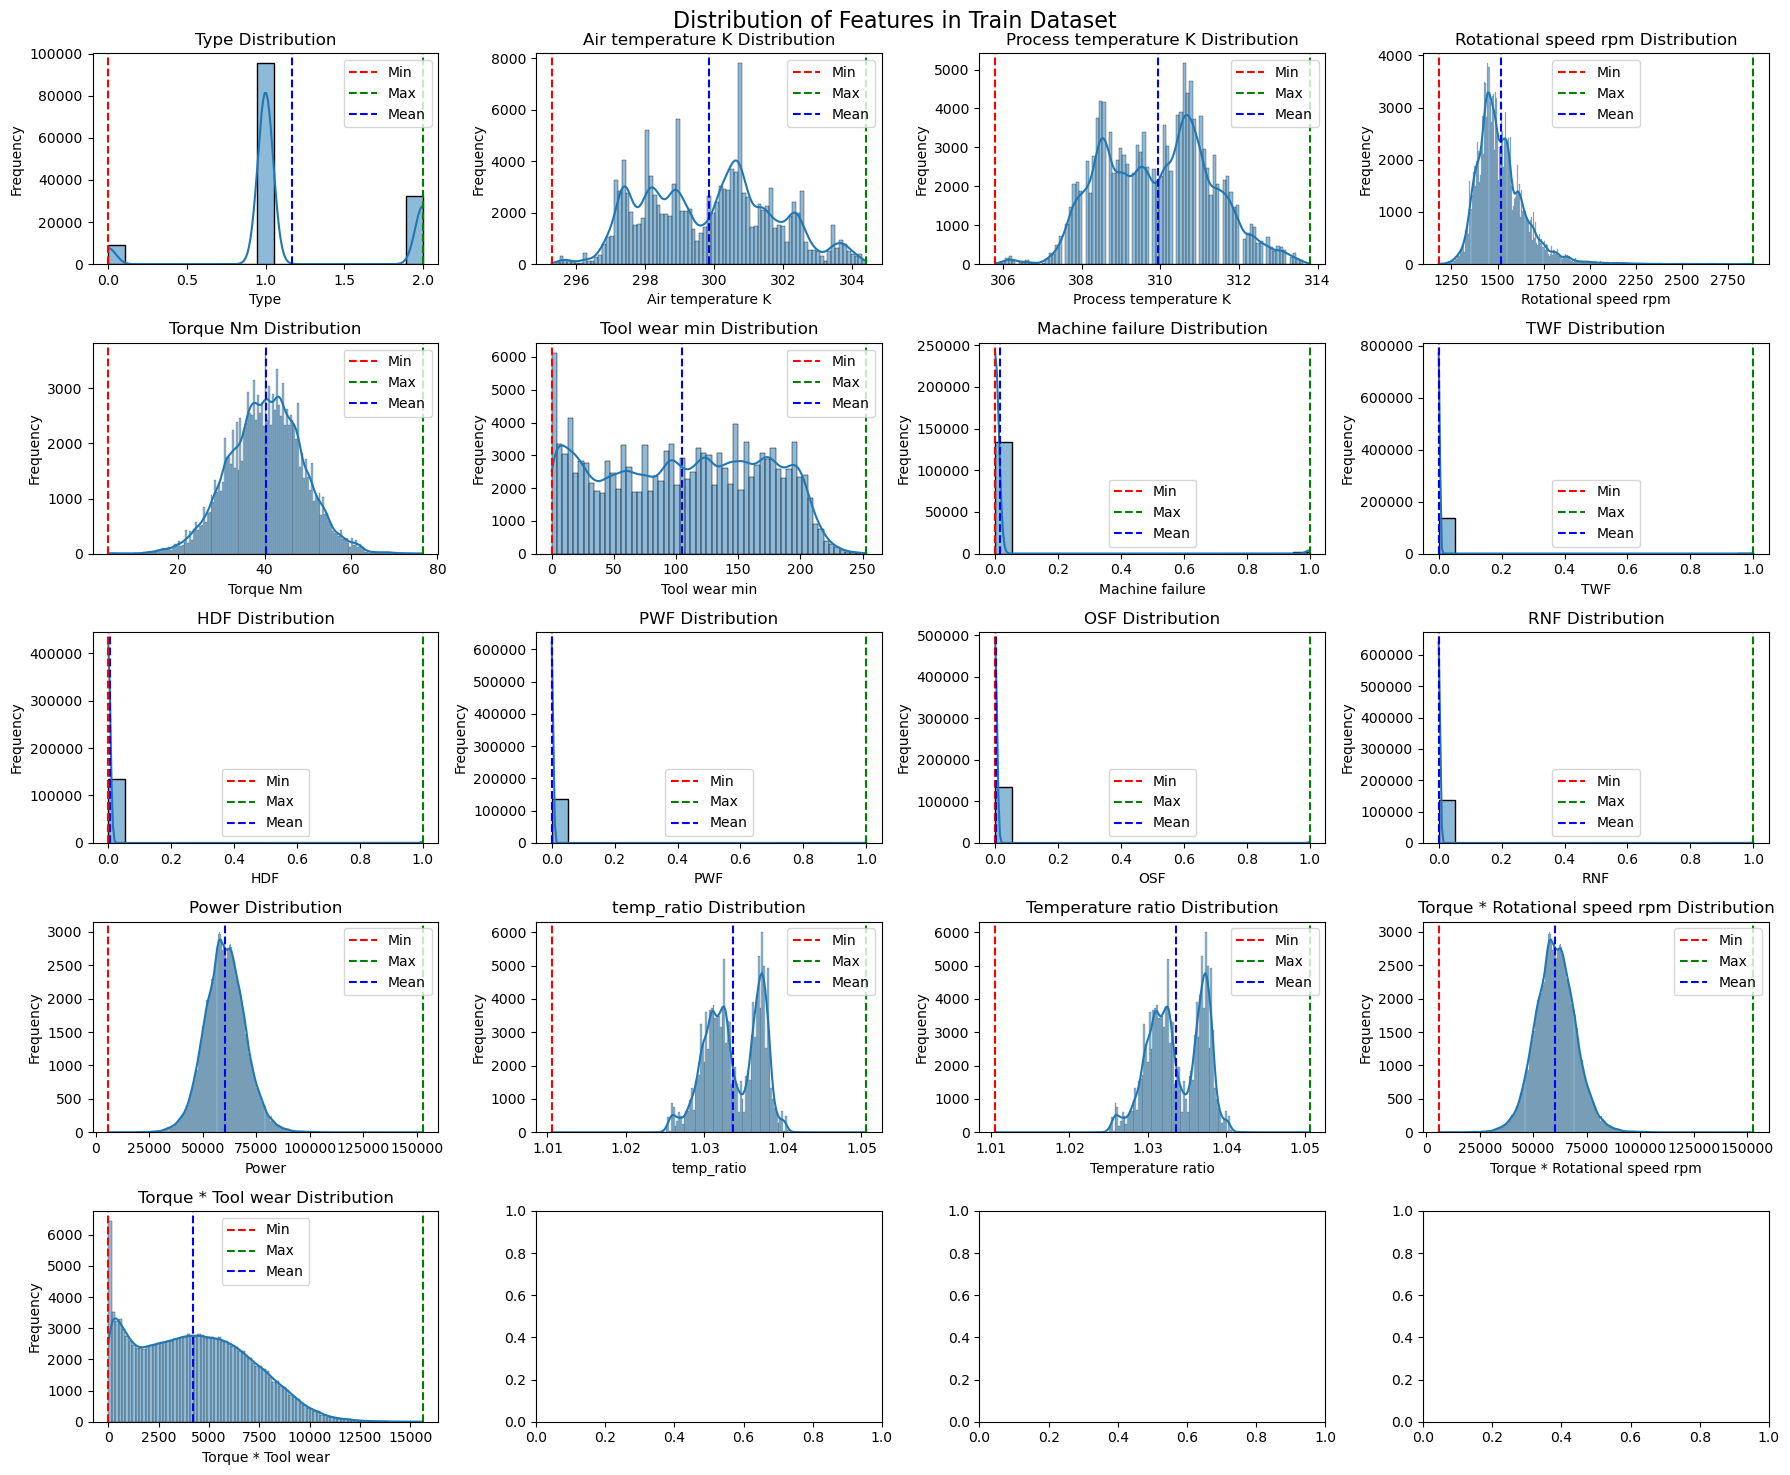

In [10]:
# numeric_columns = ['Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

numeric_columns = ['Type', 'Air temperature K',
       'Process temperature K', 'Rotational speed rpm', 'Torque Nm',
       'Tool wear min', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF',
       'Power', 'temp_ratio', 'Temperature ratio',
       'Torque * Rotational speed rpm', 'Torque * Tool wear']

num_cols = len(numeric_columns)
num_rows = math.ceil(num_cols / 4)

fig, axes = plt.subplots(num_rows, 4, figsize=(18, num_rows * 3))
fig.suptitle('Distribution of Features in Train Dataset', fontsize=16)

for i, column in enumerate(numeric_columns):
    row = i // 4
    col = i % 4
    ax = axes[row, col] if num_rows > 1 else axes[col]

    sns.histplot(data=train, x=column, kde=True, ax=ax)
    ax.set_title(f'{column} Distribution', fontsize=12)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

    min_value = train[column].min()
    max_value = train[column].max()
    mean_value = train[column].mean()
    ax.axvline(min_value, color='r', linestyle='--', label='Min')
    ax.axvline(max_value, color='g', linestyle='--', label='Max')
    ax.axvline(mean_value, color='b', linestyle='--', label='Mean')
    ax.legend()

fig.tight_layout()
plt.show()

# Correlation

In [11]:
corr = train.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm')

# PairPlot

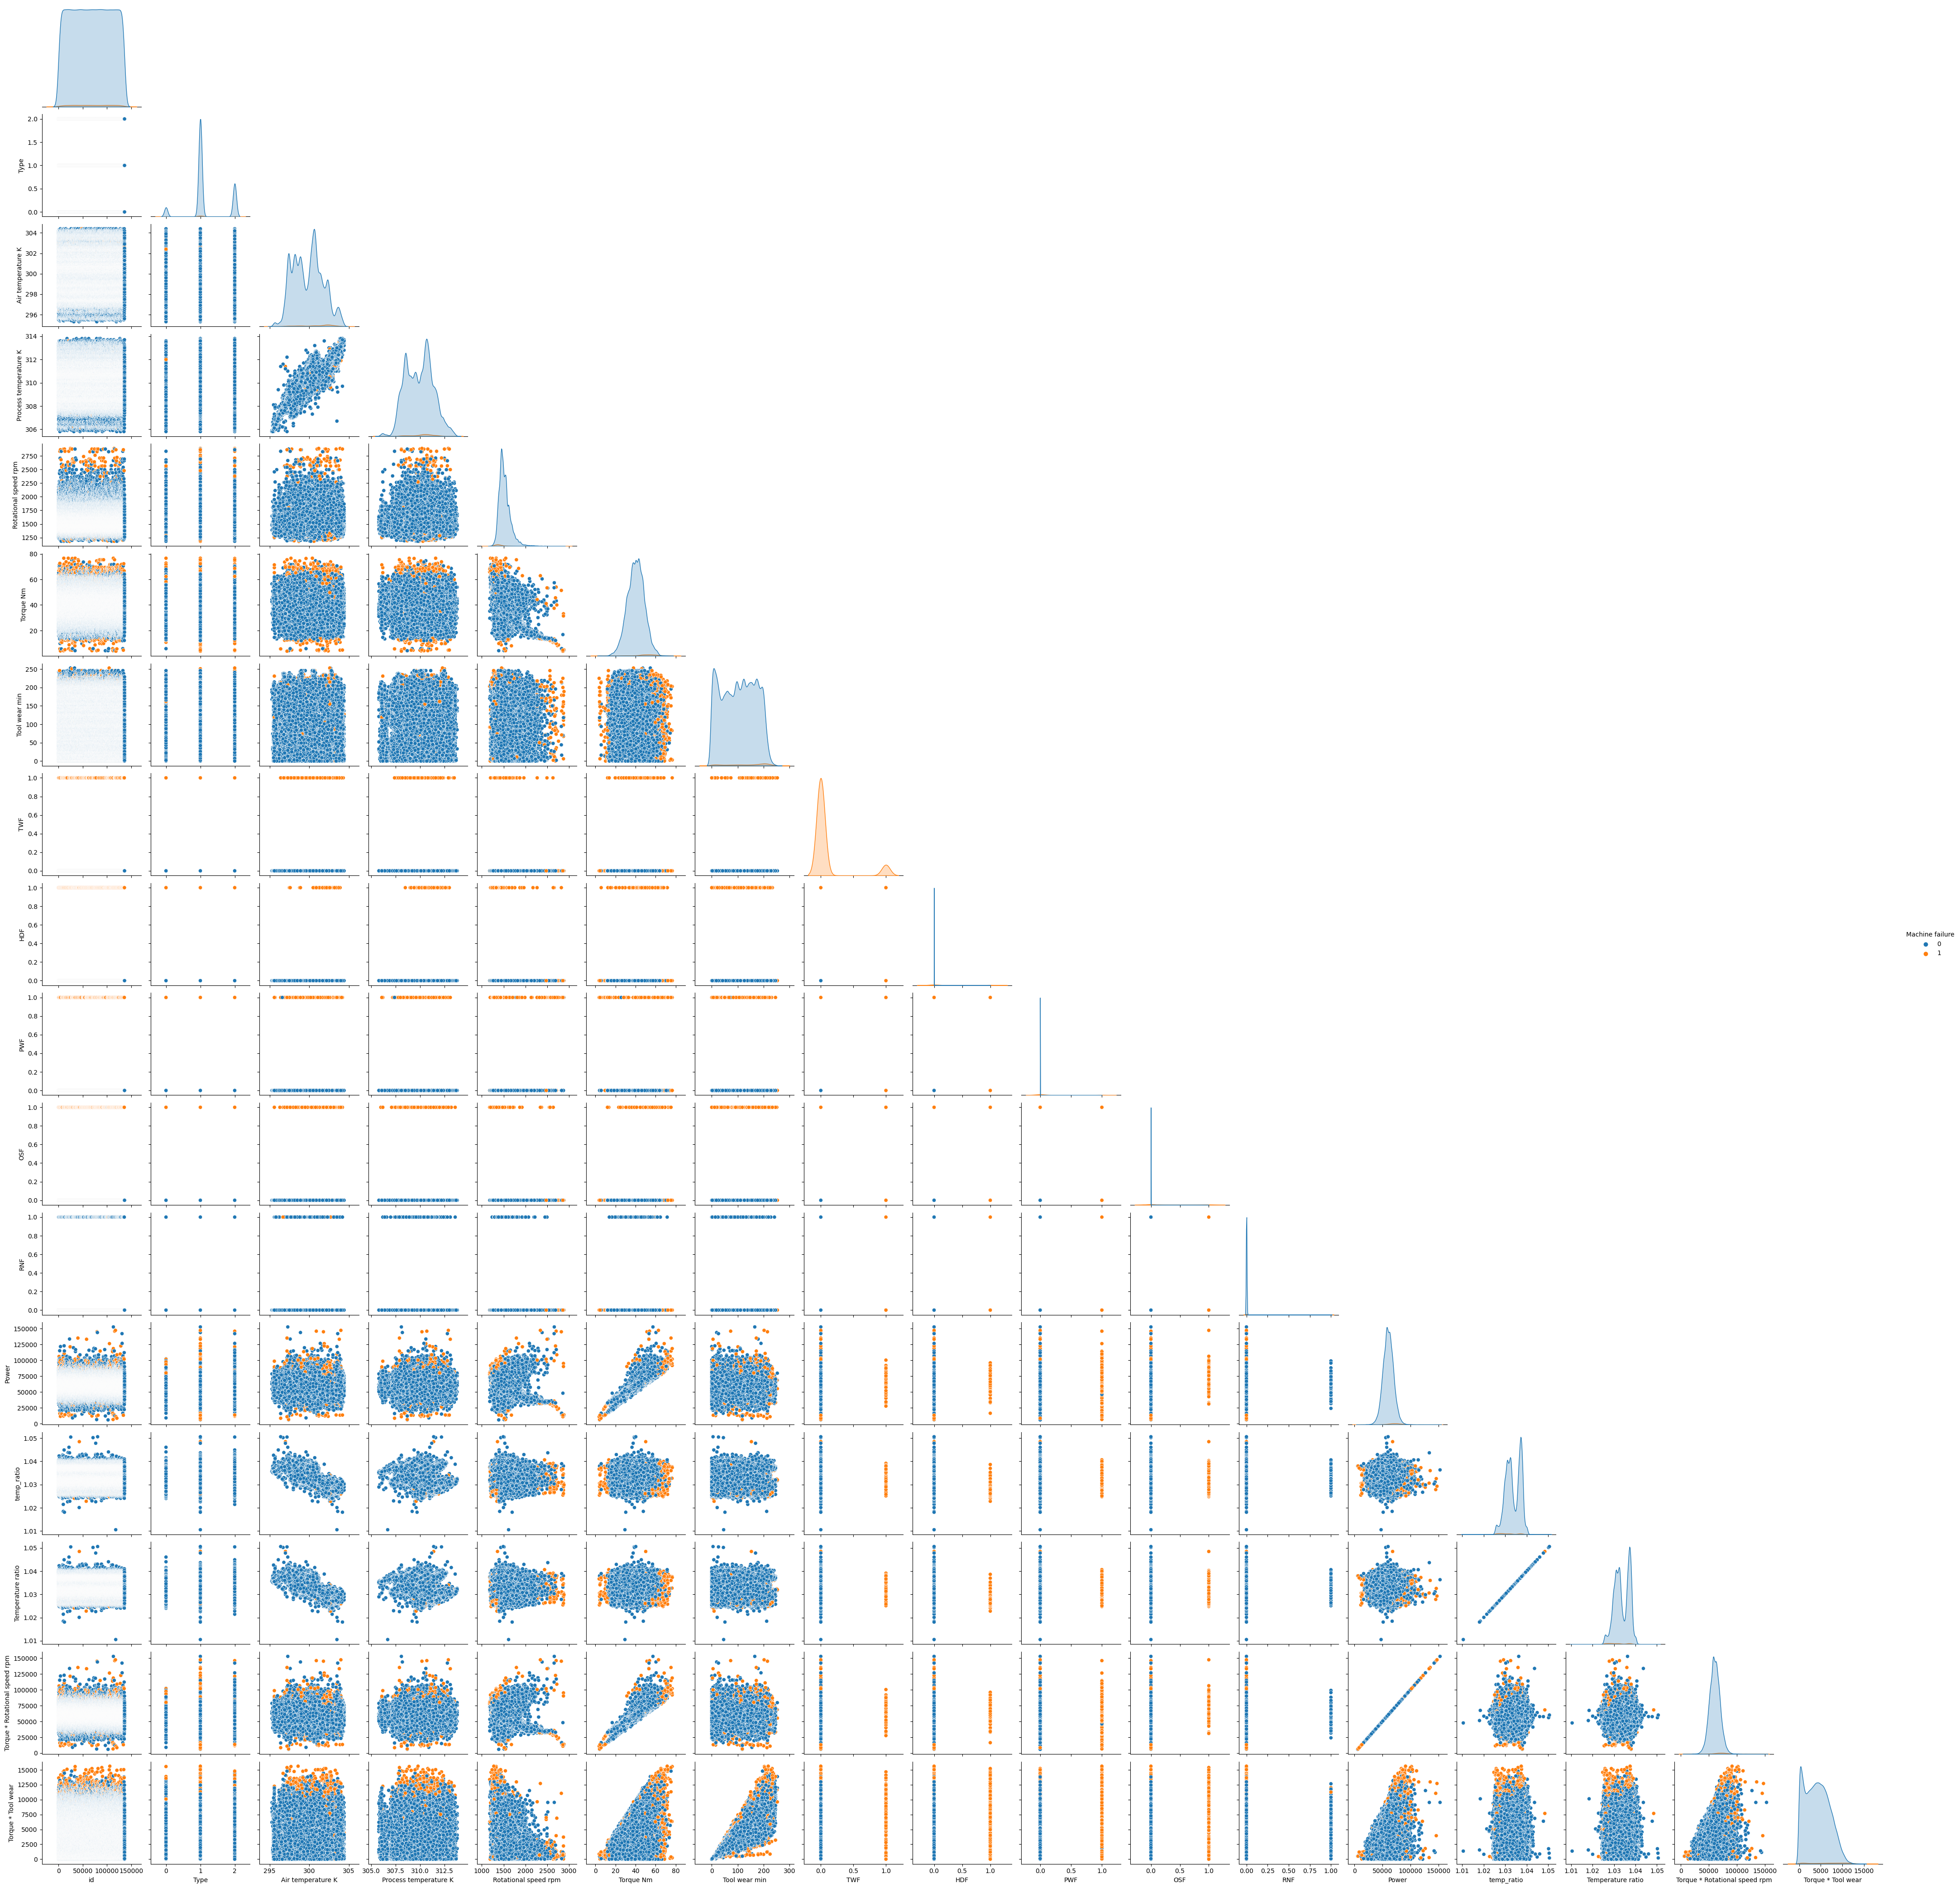

In [12]:
sns.pairplot(data = train, hue="Machine failure", corner = True);

# Outliers 

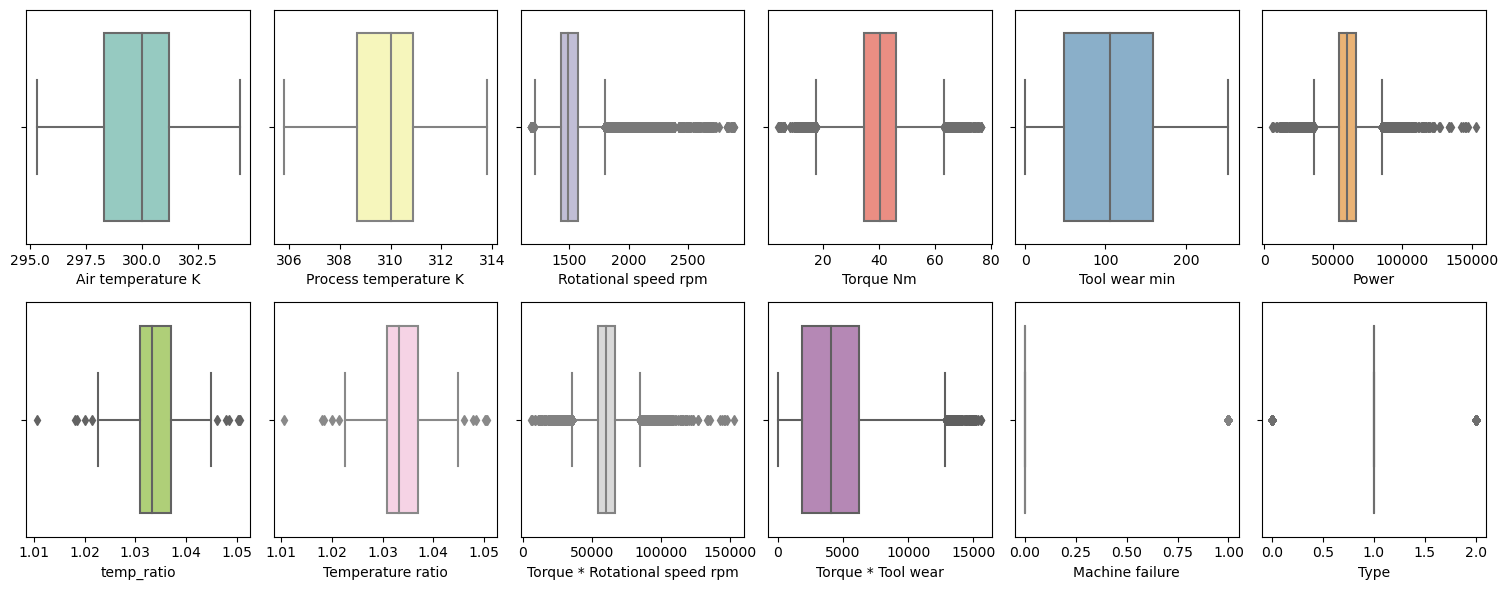

In [13]:
def boxplots(df):
    cols = ['Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm',
       'Tool wear min','Power', 'temp_ratio', 'Temperature ratio',
       'Torque * Rotational speed rpm', 'Torque * Tool wear', 'Machine failure', 'Type']
    n = (len(cols) - 1) // 6 + 1
    m = min(len(cols), 6)

    palette = sns.color_palette("Set3", len(cols))
    palette_colors = [tuple(palette[i]) for i in range(len(cols))]

    fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(15, 6))
    axes = axes.flatten()

    for idx, col in enumerate(cols):
        sns.boxplot(data=df, x=col, ax=axes[idx], palette=[palette_colors[idx]])

    plt.tight_layout()
    plt.show()

boxplots(train)

# Model

In [14]:
y = train.pop("Machine failure")
X = train.drop(["id", "Product ID"], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.8)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((109143, 16), (27286, 16), (109143,), (27286,))

In [15]:
test_df = pd.read_csv("/kaggle/input/playground-series-s3e17/test.csv")
test_df = preprocessing(test_df)
ids = test_df["id"]
test_X = test_df.drop(["id", "Product ID"], axis=1)
test_X.shape

(90954, 16)

In [16]:
from sklearn.metrics import roc_auc_score

param_dist = {
    'max_depth': [5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [200, 400, 600, 800],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1]
}

xgb = XGBClassifier()

random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, cv=3, scoring='roc_auc', n_iter=10)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

best_xgb = XGBClassifier(**best_params)
best_xgb.fit(X_train, y_train)

train_roc_score = roc_auc_score(y_train, best_xgb.predict_proba(X_train)[:, 1])
val_roc_score = roc_auc_score(y_val, best_xgb.predict_proba(X_val)[:, 1])
print("Train ROC score:", train_roc_score)
print("Validation ROC score:", val_roc_score)

Best Hyperparameters: {'subsample': 0.8, 'reg_alpha': 0.5, 'n_estimators': 800, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Train ROC score: 0.9772039394148735
Validation ROC score: 0.9685216604314462


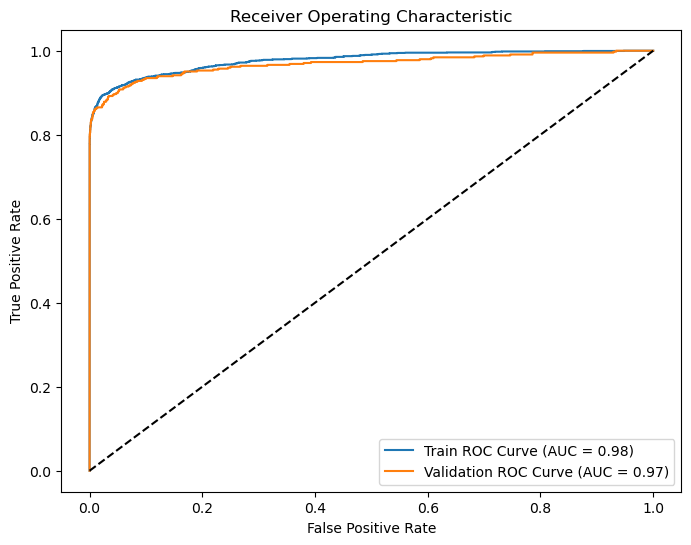

In [17]:
y_train_probs = best_xgb.predict_proba(X_train)[:, 1]
y_val_probs = best_xgb.predict_proba(X_val)[:, 1]


train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_probs)
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, y_val_probs)

train_auc = roc_auc_score(y_train, y_train_probs)
val_auc = roc_auc_score(y_val, y_val_probs)

plt.figure(figsize=(8, 6))
plt.plot(train_fpr, train_tpr, label='Train ROC Curve (AUC = {:.2f})'.format(train_auc))
plt.plot(val_fpr, val_tpr, label='Validation ROC Curve (AUC = {:.2f})'.format(val_auc))
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [18]:
# preds = best_xgb.predict_proba(test_X)
# predicted_prob = [pred[1] for pred in preds]

# submission_df = pd.DataFrame({
#     "id": ids,
#     "Machine failure": predicted_prob
# })

# submission_df.to_csv("submission9.csv", index=False)

In [19]:
# from sklearn.ensemble import GradientBoostingClassifier

# gb = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01)
# gb.fit(X_train, y_train)

# preds = gb.predict_proba(test_X)
# predicted_prob = [pred[1] for pred in preds]
# print(predicted_prob[:5])

# print('Train score:', lgbm.score(X_train, y_train))
# print('Validation score:', lgbm.score(X_val, y_val))